In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF,WhiteKernel,DotProduct
import pandas as pd
import torch



In [2]:
from snorkel import SnorkelSession
from snorkel.models import candidate_subclass
from snorkel.annotations import load_gold_labels
from snorkel.learning.pytorch import LSTM
from snorkel.annotations import load_marginals

from scipy import vstack
session = SnorkelSession()

In [3]:
ChemicalDisease = candidate_subclass('ChemicalDisease', ['chemical', 'disease'])

train = session.query(ChemicalDisease).filter(ChemicalDisease.split == 0).all()
dev = session.query(ChemicalDisease).filter(ChemicalDisease.split == 1).all()
test = session.query(ChemicalDisease).filter(ChemicalDisease.split == 2).all()

print('Training set:\t{0} candidates'.format(len(train)))
print('Dev set:\t{0} candidates'.format(len(dev)))
print('Test set:\t{0} candidates'.format(len(test)))

Training set:	8439 candidates
Dev set:	920 candidates
Test set:	4687 candidates


In [4]:
train_marginals = load_marginals(session, split=0)

In [67]:
from load_external_annotations import load_external_labels
load_external_labels(session, ChemicalDisease, split=2, annotator='gold')
L_gold_test = load_gold_labels(session, annotator_name='gold', split=2)
L_gold_dev = load_gold_labels(session,annotator_name='gold',split=1)
L_gold_train = load_gold_labels(session,annotator_name = 'gold', split=0)

AnnotatorLabels created: 0


In [70]:
L_gold_train

<8439x1 sparse matrix of type '<class 'numpy.float64'>'
	with 0 stored elements in Compressed Sparse Row format>

In [7]:
dev_labels = L_gold_dev.toarray().reshape(920,)
dev_labels[dev_labels == -1] = 0

In [69]:
train_labels_gold = L_gold_train.toarray().reshape(8439,)
train_labels_gold[train_labels_gold == -1] = 0

In [8]:
full_train_set = train.copy()
full_train_set.extend(dev)
full_train_labels = list(train_marginals).copy()
full_train_labels.extend(dev_labels)
full_train_labels = np.array(full_train_labels)


In [9]:
lstm = LSTM(n_threads=None)

lstm.load('trained_on_all_5_layers')

[LSTM] Loaded model <trained_on_all_5_layers>


In [10]:
lstm.score(test, L_gold_test)

/home/eric/anaconda3/envs/snorkel-extraction/lib/python3.6/site-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


(0.40300457217504898, 0.81344759393539878, 0.5389823105481546)

In [11]:
# am I reshaping correctly?
dev_features = lstm.feature_outputs(dev, 100).detach().numpy().reshape(920,10)
train_features = lstm.feature_outputs(train, 100).detach().numpy().reshape(8439,10)

In [12]:
dev_centered = dev_features - np.mean(dev_features, axis=0)
train_centered = train_features - np.mean(train_features, axis = 0)

In [13]:
kernel_dev = RBF(1) + WhiteKernel(1)
kernel_train = RBF(1) + WhiteKernel(1)
gpc_dev = GaussianProcessClassifier(kernel = kernel_dev)
gpc_train = GaussianProcessClassifier(kernel = kernel_train)

In [14]:
dev_norm = dev_centered / np.max(dev_centered, axis=0)
train_norm = train_centered / np.max(train_centered, axis =0)

In [15]:
train_labels = train_marginals.copy()
train_labels[train_labels > .5] = 1
train_labels[train_labels <= .5] = 0

In [63]:
dev_extended = np.concatenate((dev_features, train_features[:1000]))

In [64]:
dev_ex_cen = dev_extended - np.mean(dev_extended,axis=0)
train_small_cen = train_features[1000:] - np.mean(train_features[1000:],axis=0)

In [65]:
devex_norm = dev_ex_cen / np.max(dev_ex_cen, axis = 0)
trainex_norm = train_small_cen / np.max(train_small_cen, axis=0)

In [66]:
kernel_devex = RBF(1) + WhiteKernel(1)
kernel_trainex = RBF(1) + WhiteKernel(1)
gpc_devex = GaussianProcessClassifier(kernel = kernel_dev)
gpc_trainex = GaussianProcessClassifier(kernel = kernel_train)

In [ ]:
gpc_devex.fit(devex_norm, dev)

In [16]:
gpc_dev.fit(dev_norm, dev_labels.reshape(920,))

GaussianProcessClassifier(copy_X_train=True,
                          kernel=RBF(length_scale=1) + WhiteKernel(noise_level=1),
                          max_iter_predict=100, multi_class='one_vs_rest',
                          n_jobs=None, n_restarts_optimizer=0,
                          optimizer='fmin_l_bfgs_b', random_state=None,
                          warm_start=False)

In [17]:
gpc_dev.kernel_

RBF(length_scale=2.12) + WhiteKernel(noise_level=1e-05)

In [18]:
gpc_train.fit(train_norm, train_labels.reshape(8439,))

GaussianProcessClassifier(copy_X_train=True,
                          kernel=RBF(length_scale=1) + WhiteKernel(noise_level=1),
                          max_iter_predict=100, multi_class='one_vs_rest',
                          n_jobs=None, n_restarts_optimizer=0,
                          optimizer='fmin_l_bfgs_b', random_state=None,
                          warm_start=False)

In [19]:
gpc_train.kernel_

RBF(length_scale=1.15) + WhiteKernel(noise_level=1e-05)

In [20]:
test_features = lstm.feature_outputs(test,100).detach().numpy().reshape(4687,10)

In [21]:
test_dev_norm = (test_features - np.mean(dev_features, axis=0)) / np.max(dev_centered, axis=0)
test_train_norm = (test_features - np.mean(train_features, axis=0)) / np.max(train_centered, axis = 0)

In [22]:
gpc_train.kernel_

RBF(length_scale=1.15) + WhiteKernel(noise_level=1e-05)

In [39]:
ud = []
ut = []
preds_d = gpc_dev.predict_proba(test_dev_norm, uncertainty = ud)
preds_t = gpc_train.predict_proba(test_train_norm, uncertainty = ut)

In [24]:
preds_d

array([[ 0.60848572,  0.39151428],
       [ 0.6259474 ,  0.3740526 ],
       [ 0.62983046,  0.37016954],
       ..., 
       [ 0.87129271,  0.12870729],
       [ 0.40950771,  0.59049229],
       [ 0.56703016,  0.43296984]])

In [33]:
preds_t

array([[ 0.83794774,  0.16205226],
       [ 0.07162196,  0.92837804],
       [ 0.07068817,  0.92931183],
       ..., 
       [ 0.24684097,  0.75315903],
       [ 0.06486014,  0.93513986],
       [ 0.07476662,  0.92523338]])

In [40]:
ud = ud[0]
ut = ut[0]

In [78]:
ud = np.array(ud)

In [81]:
ud.mean()

0.050164682909455714

In [29]:
gen = (i for i,x in enumerate(ud) if x < .03)

In [32]:
test_y = L_gold_test.toarray().reshape(4687,)
test_y[test_y == -1] = 0

In [41]:
# what is the order of the probabilties? I think I was probably doingit backwards actually. 
pd, pt, pnn = [],[],[]
for x in preds_d:
    if x[0] > .5:
        pd.append(0)
    else:
        pd.append(1)
for x in preds_t:
    if x[0] > .5:
        pt.append(0)
    else:
        pt.append(1) 
for x in lstm.marginals(test):
    if x < .5:
        pnn.append(0)
    else:
        pnn.append(1) 

/home/eric/anaconda3/envs/snorkel-extraction/lib/python3.6/site-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [30]:
preds_nn = lstm.marginals(test)

In [393]:
buckets = np.linspace(0,.5,15)

In [77]:
sum(1 for x in test_y if x == 1)

1517

In [44]:
pre = gpc_train.predict(train_norm)

In [45]:
acc = []
for i in range(14):
    cor, inc = 0,0
    count  =0
    for j,p in enumerate(test_y.reshape(4687,)):
        dif = 1 - max(preds_t[j])
        if dif >= buckets[i] and dif < buckets[i+1]:
            count += 1
            if p == pre[j]:
                cor += 1
    if count > 0:
        acc.append(cor/count)
    else:
        acc.append(0)
                

<BarContainer object of 14 artists>

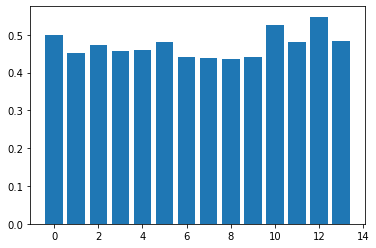

In [46]:
plt.bar(np.arange(14),acc)

In [71]:
dev_inc = set()
train_inc = set()

In [72]:
for j,p in enumerate(test_y.reshape(4687,)):
    if p != pt[j]:
        train_inc.add(j)
    if p != pd[j]:
        dev_inc.add(j)


In [134]:
train_better = dev_inc - train_inc
len(train_better)

820

In [153]:
pdworse = np.array([1 - max(x) for i,x in enumerate(preds_d) if i in train_better])
ptbetter = np.array([1 - max(x) for i,x in enumerate(preds_t) if i in train_better])

In [154]:
pdworse.mean()

0.39216067108023517

In [155]:
ptbetter.mean()

0.1727678488034656

In [138]:
pdworse = np.array([x for i,x in enumerate(ud) if i in train_better])
ptbetter = np.array([x for i,x in enumerate(ut) if i in train_better])

In [ ]:
pd

In [78]:
dev_better = train_inc - dev_inc

In [86]:
udbetter = [x for i,x in enumerate(ud) if i in dev_better]
utworse = [x for i,x in enumerate(ut) if i in dev_better]

In [158]:
preds_dbetter = [1 - max(x) for i,x in enumerate(preds_d) if i in dev_better]
preds_tworse = [1 - max(x) for i,x in enumerate(preds_t) if i in dev_better]

In [111]:
difd = np.array([1 - max(x) for i,x in enumerate(preds_d)])
dift = np.array([1 - max(x) for i,x in enumerate(preds_t)])

In [156]:
difd.mean()

0.30752262752402898

In [157]:
dift.mean()

0.20252795466746126

In [159]:
preds_dbetter = np.array(preds_dbetter)
preds_tworse = np.array(preds_tworse)
dif = preds_dbetter - preds_tworse

In [162]:
preds_tworse.mean()

0.20673914578450808

In [102]:
import math

In [103]:
math.sqrt(dif.var())

0.16605646874837807

In [87]:
utworse = np.array(utworse)
utworse.mean()

0.44849064116073106

In [83]:
udbetter = np.array(udbetter)
udbetter.mean()

0.56352302824490896

In [85]:
ud.mean()

1.0

In [438]:
count, tc, dc, bc = 0,0,0,0
dd = np.array([1-max(x) for i,x in enumerate(preds_d) if pd[i] != pt[i]])
dt = np.array([1-max(x) for i,x in enumerate(preds_t) if pd[i] != pt[i]])
y = [x for i,x in enumerate(test_y.reshape(4687,)) if pd[i] != pt[i]]
dd /= np.mean(dd)
dt /= np.mean(dt)
cdi = []
cti = []
cdc = []
ctc = []
for j,p in enumerate(y):
    if (pt[j] == pd[j]):
         continue
    count += 1
    dift = dt[j]
    difd = dd[j]
    tc = tc + (1 if pt[j] == p else 0)
    dc = dc + (1 if pd[j] == p else 0)
    if pt[j] == p:
        ctc.append(dt[j])
        cdi.append(dd[j])
    else:
        cti.append(dt[j])
        cdc.append(dd[j])
    if difd < dift:
        bc += (1 if pd[j] == p else 0)
    else:
        bc = bc + (1 if pt[j] == p else 0)

In [439]:
cdi = np.array(cdi)
cti = np.array(cti)
cdc = np.array(cdc)
ctc = np.array(ctc)

In [440]:
print(cdi.mean(), cti.mean(), cdc.mean(), ctc.mean())

1.02829123793 1.08076677756 0.98171355485 0.923058125222


In [436]:
print (count, tc, dc, bc)

973 374 599 599


In [403]:
f1scores = []
tpfp = []
tnfn = []
for i in range(14):
    count = 0
    tp,fp,tn,fn = 0,0,0,0
    for j,p in enumerate(test_y.reshape(4687,)):
        if (pt[j] == pd[j]):
             continue
        dif = 1 - max(preds_t[j])
        if dif >= buckets[i] and dif < buckets[i+1]:
            count += 1
            if p == 0 and pt[j] == 0:
                tn += 1
            elif p == 0 and pt[j] == 1:
                fp += 1
            elif p == 1 and pt[j] == 0:
                fn += 1
            else: #p == 1 and preds[j] == 1:
                tp += 1
    try:
        p = tp / (tp + fp)
    except:
        p = 0
    try:
        r = tp / (tp + fn)
    except: 
        r = 0
    try:
        f1 = 2/(1/p + 1/r)
    except:
        f1 = 0
    f1scores.append(f1)
    try:
        tpfp.append(tp/(tp +fp))
    except:
        tpfp.append(0)
    try:
        tnfn.append(tn/(tn +fn))
    except:
        tnfn.append(0)
    print ("Bucket {}: \n Count: {}\n F1: {}\n{},{},{},{}".format(buckets[i+1], count, f1,tp,fp,tn,fn))

Bucket 0.03571428571428571: 
 Count: 5
 F1: 0.7499999999999999
3,2,0,0
Bucket 0.07142857142857142: 
 Count: 280
 F1: 0.6374695863746959
131,149,0,0
Bucket 0.10714285714285714: 
 Count: 392
 F1: 0.673434856175973
199,193,0,0
Bucket 0.14285714285714285: 
 Count: 207
 F1: 0.5821917808219178
85,122,0,0
Bucket 0.17857142857142855: 
 Count: 172
 F1: 0.5108225108225108
59,113,0,0
Bucket 0.21428571428571427: 
 Count: 317
 F1: 0.5186915887850467
111,206,0,0
Bucket 0.25: 
 Count: 261
 F1: 0.4181818181818182
69,192,0,0
Bucket 0.2857142857142857: 
 Count: 121
 F1: 0.4078947368421052
31,90,0,0
Bucket 0.3214285714285714: 
 Count: 93
 F1: 0.546875
35,58,0,0
Bucket 0.3571428571428571: 
 Count: 68
 F1: 0.47191011235955055
21,47,0,0
Bucket 0.39285714285714285: 
 Count: 67
 F1: 0.5111111111111111
23,44,0,0
Bucket 0.42857142857142855: 
 Count: 59
 F1: 0.3611111111111111
13,46,0,0
Bucket 0.46428571428571425: 
 Count: 63
 F1: 0.5176470588235293
22,41,0,0
Bucket 0.5: 
 Count: 67
 F1: 0.4235294117647059
18,49

<BarContainer object of 14 artists>

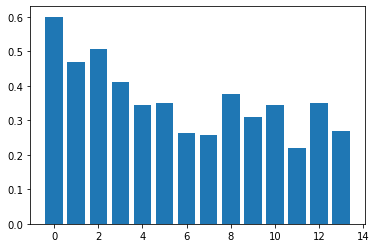

In [404]:
plt.bar(np.arange(14),tpfp)

<BarContainer object of 14 artists>

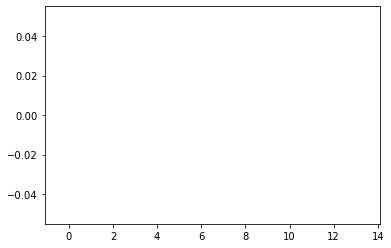

In [405]:
plt.bar(np.arange(14),tnfn)

<BarContainer object of 14 artists>

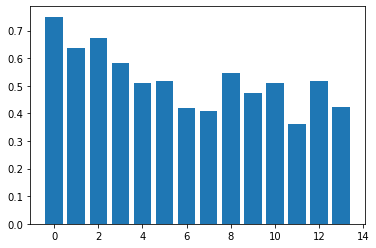

In [406]:
plt.bar(np.arange(len(f1scores)),f1scores)

In [398]:
import scipy.stats
import math

In [102]:
dif_t = .5
var = .1

In [48]:
ud = ud / ud.mean()
ut = ut / ut.mean()

In [50]:
cd = 1/ud
ct = 1 /ut

In [51]:
cd

array([ 0.68881144,  0.87057306,  2.14365117, ...,  0.52434997,
        0.66326727,  1.68781971])

In [362]:
scipy.stats.norm.cdf(.5, .75, .1)

0.0062096653257761323

In [190]:
import scipy.stats

In [386]:
buckets = np.linspace(-.5,.5,100)
f1scores = []
acc = []
for b in buckets:
    tp,fp,tn,fn = 0,0,0,0
    for j,p in enumerate(test_y.reshape(4687,)):
        if (pd[j] != pt[j]):
            continue
#         dif_t = abs(preds_t[j][0] - preds_t[j][1])
#         dif_d = abs(preds_d[j][0] - preds_d[j][1])
#         t_vote = (1-dif_t) * ct[j]
#         d_vote = (1-dif_d) * cd[j]
        #switch_d = scipy.stats.norm.cdf(.5, max(preds_d[j]), math.sqrt(ud[j]))
        #switch_t = scipy.stats.norm.cdf(.5, max(preds_t[j]), math.sqrt(ut[j]))
        #t_vote = (1-dif_t) # (1- scipy.stats.norm.cdf(.5, dif_t + .5, math.sqrt(ut[j])))# * dif_t
        #d_vote = #(1- scipy.stats.norm.cdf(.5, dif_d + .5, math.sqrt(ud[j])))# * dif_d
        pr = pd[j]
#         if switch_d - switch_t < b:
#             pr = pd[j]
#         else:
#             pr = pt[j]
        if p == 0 and pr == 0:
            tn += 1
        elif p == 0 and pr == 1:
            fp += 1
        elif p == 1 and pr == 0:
            fn += 1
        else: #p == 1 and preds[j] == 1:
            tp += 1
    p = tp / (tp + fp)
    r = tp / (tp + fn)
    f1 = 2 / (1/p + 1/r)
    f1scores.append(f1)
    acc.append((tp + tn) / (tp + fn + tn + fp))

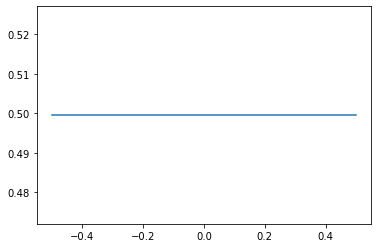

In [387]:
plt.plot(buckets,f1scores)

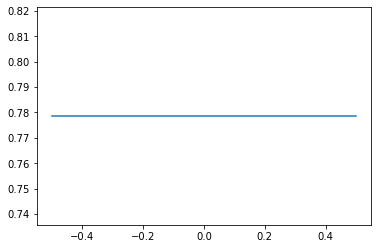

In [388]:
plt.plot(buckets,acc)

In [310]:
f1scores = []
tpfp = []
tnfn = []
tp,fp,tn,fn = 0,0,0,0


# for i in range(14):
#     count = 0
for j,p in enumerate(test_y.reshape(4687,)):
    dif_t = 1 - max(preds_t[j])
    dif_d = 1 - max(preds_d[j])
    pr = 0
    if dif_t> 0.25:
        pr = pd[j]
    else:
        pr = pt[j]
#     weighted = (cd[j] * preds_d[j][1] + ct[j] * preds_t[j][1]) / (ct[j] + cd[j])
#     pr = pt[j]
#     if weighted > .5:
#         pr = pt[j]
#     if dif_t - dif_d > .2:
#         print ("here")
#         pr = pd[j]
#         print (pr == p)
#         if dif_t < dif_d:
#             pr = pt[j]
#         else:
#             pr = pd[j]
#         if abs(dif_t - dif_d) < .04:
#             if ud[j] < ut[j]:
#                 pr = pd[j]
#             else:
#                 pr = pt[j]
#     t_vote = (1- scipy.stats.norm.cdf(.5, dif_t + .5, math.sqrt(ut[j]))) * dif_t
#     d_vote = (1- scipy.stats.norm.cdf(.5, dif_d + .5, math.sqrt(ud[j]))) * dif_d
#     if t_vote < d_vote:
#         pr = pt[j]
#     else:
#         pr = pt[j]
#         if dif >= buckets[i] and dif < buckets[i+1]:
#             count += 1
    if p == 0 and pr == 0:
        tn += 1
    elif p == 0 and pr == 1:
        fp += 1
    elif p == 1 and pr == 0:
        fn += 1
    else: #p == 1 and preds[j] == 1:
        tp += 1
#     try:
#         p = tp / (tp + fp)
#     except:
#         p = 0
#     try:
#         r = tp / (tp + fn)
#     except: 
#         r = 0
#     try:
#         f1 = 2/(1/p + 1/r)
#     except:
#         f1 = 0
#     f1scores.append(f1)
#     try:
#         tpfp.append(tp/(tp +fp))
#     except:
#         tpfp.append(0)
#     try:
#         tnfn.append(tn/(tn +fn))
#     except:
#         tnfn.append(0)
p = tp / (tp + fp)
r = tp / (tp + fn)
print(2 / (1/p + 1/r))
#print ("Bucket {}: \n Count: {}\n F1: {}\n{},{},{},{}".format(buckets[i+1], count, f1,tp,fp,tn,fn))

0.5242500700869078


In [311]:
print(tp,fp,tn,fn)

935 1115 2055 582


In [312]:
print ((tp + tn)/(tp+fp+tn+fn))

0.6379347130360572


<BarContainer object of 0 artists>

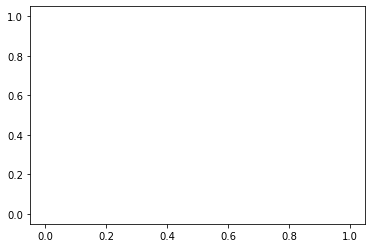

In [313]:
plt.bar(np.arange(len(f1scores)),f1scores)

In [89]:
tp,fp,tn,fn = 0,0,0,0
for j,p in enumerate (test_y):
        if p == 0 and pt[j] == 0:
            tn += 1
        elif p == 0 and pt[j] == 1:
            fp += 1
        elif p == 1 and pt[j] == 0:
            fn += 1
        else: #p == 1 and preds[j] == 1:
            tp += 1
try:
    p = tp / (tp + fp)
except:
    p = 0
try:
    r = tp / (tp + fn)
except: 
    r = 0
try:
    f1 = 2/(1/p + 1/r)
except:
    f1 = 0

In [90]:
f1

0.5403824521934758

In [91]:
p

0.4101775956284153

In [92]:
dev_cov= np.matmul(dev_features.detach().numpy().reshape(920,10).transpose(), dev_features.detach().numpy().reshape(920,10))

AttributeError: 'numpy.ndarray' object has no attribute 'detach'

In [ ]:
np.linalg.svd(dev_cov)

In [ ]:
gpc_d.score(test_features, test_y)

In [270]:
confdif = np.abs((difd - dift))

In [290]:
buckets = np.linspace(0,.5,3)

In [291]:
vals = []
for i in range(2):
    count = 0
    match = 0
    for j,p in enumerate(test_y.reshape(4687,)):

        if confdif[j] >= buckets[i] and confdif[j] < buckets[i+1]:
            count += 1
            if pt[j] == pd[j]:
                match += 1
    if count > 0:
        vals.append(match / count)
    else:
        vals.append(0)

<BarContainer object of 2 artists>

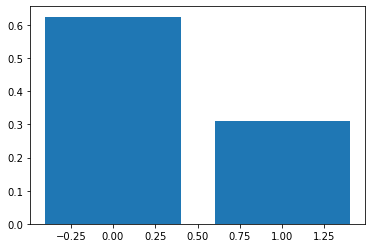

In [292]:
plt.bar(np.arange(2), vals)

In [285]:
len(vals)

14